<h1>Taller 4.1: Embeddings y Redes Recurrentes

In [11]:
#Celda 1: Importación de Librerías
#Esta celda importa todas las bibliotecas necesarias para la construcción, entrenamiento y evaluación del modelo.

# Importacion de Librerias
import tensorflow as tf             # Librería principal de código abierto para aprendizaje automático.
from keras.models import Sequential # Se utiliza para inicializar la red neuronal secuencial (por capas).
import numpy as np                  # Utilizada para operaciones numéricas y manejo de arrays de datos.
from keras.utils import pad_sequences # Función específica para asegurar que todas las secuencias de entrada tengan la misma longitud.
from sklearn.model_selection import train_test_split # Utilizada para dividir el dataset en conjuntos de entrenamiento y validación.
from keras.layers import Dense, Embedding, SimpleRNN # Capas de la red: Dense (capa regular), Embedding (vectorización de palabras), SimpleRNN (red recurrente).
import string                       # Módulo con constantes para operaciones con cadenas de texto (e.g., puntuación).
import datetime                     # Utilizada para manejar fechas y generar un nombre de registro único (tag) para TensorBoard.
import nltk                         # Toolkit para el procesamiento del lenguaje natural (NLP).
from nltk.tokenize import sent_tokenize,word_tokenize # Funciones de NLTK para tokenizar texto en oraciones y palabras.

Hasta ahora hemos visto como procesar información tabular, usando redes neuronales, para resolver problemas de predicción a través de regresión, o problemas de clasificación. Sin embargo, existen conjuntos de datos
en donde el orden contiene información. Ejemplos de este tipo de datos, es el lenguaje hablado, en donde el orden de las palabras, y no su presencia o ausencia (enfoque tabular), determina el significado de una frase u
oración. Este tipo de dato, además tiene la característica de que la cantidad de palabras que se usan en el lenguaje es muy alto (vocabulario en el orden de cientos o miles de palabras), lo que hace imposible usar técnicas
que se usan para otro tipo de datos categóricos, como one hot encoding, que revisamos en el taller 2 y 3.
Para procesar este tipo de información es necesario usar modelos que puedan:
1. Representar la alta variabilidad de las entradas, tales como el lenguaje escrito, y codificarlo en una representación vectorial que los modelos puedan interpretar.
2. Recordar elementos de una secuencia para clasificar o predecir los siguientes elementos. Un ejemplo de esto es cuando escuchamos una frase y recordamos el sujeto para que cuando escuchemos el predicado
podamos hacer sentido de la oración.
Para resolver el problema 1, se usa una técnica denominada vectorización, que genera un embedding (vector de N componentes) que codifica la variabilidad de una secuencia categórica.
Para resolver el problema 2, se usan redes que tienen memoria, llamadas redes recurrentes, o redes que construyen representaciones vectoriales de las relaciones entre los elementos de una secuencia, los transformers.
Para trabajar en esta ocasión construimos un clasificador de mensajes spam. Para eso usaremos el siguiente dataset de SMS en inglés, en donde cada mensaje indica si es spam o no ("ham").

In [12]:
#Celda 2: Carga del Dataset
#Esta celda abre el archivo del dataset de mensajes SMS.

# Carga del archivo del dataset (se asume que 'sms.txt' está disponible en el mismo directorio)
dataset = open("sms.txt")

El primer paso consiste en tokenizar los mensajes en las palabras que lo constituyen y asignar un código numérico a cada palabra distinta: este proceso es lo mismo que se haría cuando se usa el label encoder con datos
categóricos. Puedes intentar construir un clasificador usando los códigos numéricos (tokens) generados, pero no será muy efectivo porque los números que le asignamos a cada palabra son arbitrarios y no guardan
ninguna relación matemática profunda entre sí, por lo que al intentar usar modelos matemáticos para representarlos solamente serán muy aproximados y basados en similitudes arbitrarias.

In [13]:
#Celda 3: Tokenización, Limpieza y Conteo de Vocabulario
#Esta celda procesa el texto de los mensajes, limpia la puntuación, los divide en palabras y construye el vocabulario, asignando una etiqueta binaria (0 o 1) a cada mensaje.

# Descarga de recursos de NLTK si no están presentes (necesarios para la tokenización)
nltk.download('punkt')
nltk.download('punkt_tab')

X=[] # Lista para almacenar los mensajes de texto (secuencias de palabras).
Y=[] # Lista para almacenar las etiquetas de clase (0 para 'ham', 1 para 'spam').
vocabulario={} # Diccionario para llevar el conteo de frecuencia de cada palabra.

# Generador de tabla de traducción para eliminar la puntuación.
translator = str.maketrans(dict.fromkeys(string.punctuation))

# Itera sobre cada línea del archivo dataset
for linea in dataset:
    # Separa la etiqueta ('spam' o 'ham') del texto del mensaje
    label,text=linea.strip().split("\t")
    
    # Elimina la puntuación del texto usando la tabla de traducción
    text=text.translate(translator)
    
    message=[] # Lista temporal para las palabras del mensaje actual
    
    # Tokeniza el texto en oraciones y luego en palabras
    for i in sent_tokenize(text):
        for j in word_tokenize(i):
            palabra=j.lower() # Convierte la palabra a minúsculas
            message.append(palabra)
            
            # Conteo de frecuencia de palabras para construir el vocabulario
            if palabra in vocabulario:
                vocabulario[palabra]+=1
            else:
                vocabulario[palabra]=1
    
    X.append(message) # Agrega la lista de palabras del mensaje a X
    
    # Asigna la etiqueta numérica: [1] si es "spam", [0] si es "ham"
    y=[1] if label=="spam" else [0]
    Y.append(y)

# Imprime el tamaño del vocabulario (cantidad de palabras únicas)
print(len(vocabulario.keys()))

[nltk_data] Downloading package punkt to /home/johndoe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/johndoe/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


9636


In [14]:
#Celda 4: Importación del Tokenizador de Keras
#Se importa la herramienta Tokenizer de Keras, que asigna índices a las palabras según su frecuencia.

# Importa la clase Tokenizer de Keras para preprocesamiento de texto
from tensorflow.keras.preprocessing.text import Tokenizer

In [15]:
#Celda 5: Visualización del Primer Mensaje Tokenizado (por NLTK)
#Se muestra cómo quedó el primer mensaje después de la limpieza y tokenización inicial con NLTK (como lista de palabras).

# Muestra la lista de palabras del primer mensaje en el conjunto X
X[0]

['go',
 'until',
 'jurong',
 'point',
 'crazy',
 'available',
 'only',
 'in',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'there',
 'got',
 'amore',
 'wat']

En este paso, usando las funcionalidades de keras, generamos los tokens asociados a cada palabra de cada mensaje.

In [16]:
#Celda 6: Ajuste e Indexación de Keras Tokenizer
#Esta celda ajusta el Tokenizer de Keras a los datos y convierte las secuencias de palabras en secuencias de índices numéricos (tokens).

# Inicializa el objeto Tokenizer de Keras
tokenizer = Tokenizer()

# Ajusta el tokenizer a los textos para construir el índice de palabras (word_index)
tokenizer.fit_on_texts(X)

# Convierte las listas de palabras (X) en listas de índices numéricos (tokens)
sequences = tokenizer.texts_to_sequences(X)

In [17]:
#Celda 7: Visualización de Tokens Numéricos
#Se muestra cómo quedó el primer mensaje después de ser convertido a secuencias de índices numéricos por Keras.

# Muestra la secuencia de tokens numéricos (índices de palabras) del primer mensaje
sequences[0]

[46,
 442,
 4385,
 798,
 716,
 680,
 64,
 9,
 1250,
 89,
 120,
 356,
 1251,
 154,
 2898,
 1252,
 67,
 55,
 4386,
 137]

Podemos ver que para los 5574 mensajes, tenemos 9636 palabras distintas, lo que muestra el problema de la alta dimensionalida del lenguaje. Si quisiéramos usar one hot encoding para representar cada palabra,
necesitaríamos un vector de 9636 componentes.

In [18]:
#Celda 8: Extracción y Conteo Final de Vocabulario
#Se extraen las palabras indexadas por Keras y se calcula el tamaño final del vocabulario, que incluye el índice 0 para padding.

# Obtiene la lista ordenada de palabras según el índice de Keras Tokenizer
words=list(tokenizer.word_index.keys())
print(words) # Esto imprime el vocabulario completo (útil para inspección)

# Define el tamaño del vocabulario (+1 porque Keras reserva el índice 0 para padding)
vocabulary=len(words)+1
print(len(vocabulario.keys())) # Imprime el conteo original de palabras (de la Celda 3)


['to', 'i', 'you', 'a', 'the', 'u', 'and', 'is', 'in', 'me', 'my', 'for', 'your', 'it', 'of', 'call', 'have', 'on', 'that', 'are', '2', 'now', 'im', 'not', 'so', 'but', 'or', 'can', 'at', 'do', 'ur', 'get', 'be', 'will', 'if', 'with', 'just', 'we', 'no', 'this', 'its', 'up', '4', 'dont', 'when', 'go', 'ok', 'from', 'free', 'all', 'out', 'how', 'what', 'know', 'got', 'like', 'ill', 'good', 'then', 'was', 'come', 'am', 'time', 'only', 'day', 'love', 'there', 'want', 'send', 'text', 'he', 'as', 'by', 'going', 'one', 'ü', 'need', 'about', 'txt', 'home', 'lor', 'see', 'sorry', 'still', 'r', 'back', 'stop', 'our', 'n', 'reply', 'today', 'mobile', 'tell', 'new', 'well', 'later', 'hi', 'think', 'been', 'da', 'she', 'any', 'please', 'take', 'they', 'her', 'phone', 'cant', 'did', 'some', 'here', 'has', 'week', 'night', 'an', 'claim', 'oh', 'who', 'much', 'great', 'hey', 'dear', 'him', 'more', 'pls', 'happy', 'na', 'd', 'too', 'hope', 'had', 'give', 'make', 'way', 'where', 'work', 'wat', 'should'

Necesitamos que todas las secuencias tengan la misma longitud para que el modelo las pueda procesar correctamente. Para eso usamos la función pad_sequences, que rellena con 0 las secuencias más cortas que las
demás y las deja todas en el mismo largo (l=171). Es por esto también, que la numeración de los tokens comienza en 1, porque el cero se usa como relleno (padding).

In [19]:
#Celda 9: Relleno de Secuencias (Padding)
#Se utiliza pad_sequences para estandarizar la longitud de todos los mensajes, rellenando los más cortos con ceros.

# Rellena las secuencias para que todas tengan la misma longitud.
# La longitud se determina automáticamente por la secuencia más larga.
X = pad_sequences(sequences)

In [20]:
#Celda 10: Verificación de la Forma del Dataset (Shape)
#Se verifica la forma del conjunto de datos X después del padding.

# Muestra la forma (número de muestras, longitud máxima de secuencia) del dataset X
X.shape

(5574, 171)

In [21]:
# Celda 11: Preparación de Variables para el Modelo
# Se establece la longitud de entrada y se convierten los conjuntos X e Y a arrays de NumPy.

# La longitud de entrada es el largo de la primera secuencia (que ahora es la longitud máxima, 171)
input_length=len(X[0])

# Imprime el tamaño del vocabulario y la longitud de entrada máxima
print(vocabulary,input_length)

# Convierte las listas X e Y a arrays de NumPy, requisito para el entrenamiento en Keras/TensorFlow
X=np.asarray(X)
Y=np.asarray(Y)


9637 171


Ahora continuamos con el proceso habitual, creando el conjunto de entrenamiento y de test.
También podríamos usar oversampling o undersampling, hacerlo en este caso queda como ejercicio para ti.

In [22]:
# Celda 12: División en Conjuntos de Entrenamiento y Validación
# Se utiliza train_test_split para separar los datos en conjuntos de entrenamiento (80%) y validación (20%), manteniendo la proporción de clases (spam/ham) con stratify=Y.

# Divide los datos en entrenamiento (80%) y validación (20%)
# stratify=Y asegura que la proporción de spam/ham se mantenga en ambos conjuntos.
# random_state=1 asegura que la división sea reproducible.
x_train,x_val,y_train,y_val=train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=1)


En este modelo podemos ver dos cosas nuevas:
1. La capa embedding genera la vectorización a partir de la entrada con forma (muestras, 171) y la tranforma en una secuencia con tres dimensiones (muestras, 171, 64), donde 64 es el tamaño del embedding: cada token se convierte en un vector de 64 componentes. Queda como ejercicio para ti variar el tamaño del embedding y verificar su efecto en el rendimiento de la red.

2. La capa SimpleRNN representa una red recurrente, y el número 64 es el número de unidades de la capa (o tamaño del estado oculto), al igual que en el caso de la capa Dense. keras soporta varios tipos de redes recurrentes, que puedes probar:
- SimpleRNN LSTM GRU

In [23]:
# Celda 13: Definición de la Arquitectura del Modelo (SimpleRNN)
# Se define la arquitectura secuencial, que incluye la capa de Embedding, la capa SimpleRNN y la capa Dense de salida.

# Inicializa el modelo secuencial (por capas)
modelo=Sequential()

# 1. Capa de Embedding: Convierte los tokens en vectores densos
# input_dim: Tamaño del vocabulario (9637)
# output_dim: Dimensión del embedding (cada palabra se mapea a un vector de 64 componentes)
modelo.add(Embedding(input_dim=vocabulary,output_dim=64))

# 2. Capa Recurrente Simple (SimpleRNN)
# 64: Número de unidades/neuronas o tamaño del estado oculto (memoria de la red)
modelo.add(SimpleRNN(64))

# 3. Capa de Salida Densa
# 1: Una única neurona para la clasificación binaria
# activation="sigmoid": Función de activación para obtener una probabilidad entre 0 y 1
modelo.add(Dense(1,activation="sigmoid"))

# Muestra el resumen del modelo, incluyendo la cantidad de parámetros de cada capa
modelo.summary()

2025-11-24 11:50:42.714135: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Procedemos con el entrenamiento del modelo como en los casos anteriores.

In [24]:
# Celda 14: Compilación del Modelo
# Se configura el optimizador, la función de pérdida y las métricas a monitorear.

# Compila el modelo
# optimizer="Adam": Un optimizador popular y eficiente.
# loss="binary_crossentropy": Función de pérdida adecuada para problemas de clasificación binaria (spam vs. ham).
# metrics=["acc"]: Métrica a monitorear durante el entrenamiento (accuracy o exactitud).
modelo.compile(optimizer="Adam",loss="binary_crossentropy",metrics=["acc"])

In [25]:
# Celda 15: Entrenamiento del Modelo
# Se realiza el entrenamiento del modelo sobre los datos, utilizando el conjunto de validación para monitorear el rendimiento.

# Genera un tag único basado en la fecha y hora para el registro en TensorBoard
tag="rnn"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag

# Callback para visualizar el progreso del entrenamiento en TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Entrena el modelo (Fit)
spam=modelo.fit(
    x_train, # Datos de entrada para entrenamiento
    y_train, # Etiquetas de salida para entrenamiento
    validation_data=(x_val,y_val), # Datos para evaluar el rendimiento durante el entrenamiento
    batch_size=32, # Tamaño de los lotes de datos procesados por iteración
    epochs=4, # Número de veces que el modelo verá todo el conjunto de entrenamiento
    verbose=2, # Muestra un registro de progreso conciso por época
    callbacks=[tensorboard_callback] # Incluye el callback de TensorBoard
)

Epoch 1/4
140/140 - 6s - 41ms/step - acc: 0.9334 - loss: 0.1918 - val_acc: 0.9713 - val_loss: 0.0954
Epoch 2/4
140/140 - 3s - 22ms/step - acc: 0.9888 - loss: 0.0428 - val_acc: 0.9848 - val_loss: 0.0963
Epoch 3/4
140/140 - 3s - 22ms/step - acc: 0.9874 - loss: 0.0444 - val_acc: 0.9848 - val_loss: 0.0593
Epoch 4/4
140/140 - 5s - 35ms/step - acc: 0.9969 - loss: 0.0126 - val_acc: 0.9839 - val_loss: 0.0619


In [28]:
# Celda 16: Importación de Métricas de Evaluación
# Se importan las funciones de sklearn.metrics necesarias para la evaluación detallada del modelo (Matriz de Confusión, Precisión, Recall, etc.).

# Importación de métricas de evaluación del módulo sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# Importación de librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# Celda 17: Predicción de Probabilidades
# Se utiliza el modelo entrenado para predecir las probabilidades de que los mensajes en el conjunto de validación sean spam.

# Realiza predicciones en el conjunto de validación
# Retorna un array de probabilidades (entre 0 y 1)
y_pred_probs=modelo.predict(x_val)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


Al analizar los resultados, podemos ver que nuestro filtro de spam combinando embeddings y redes recurrentes tiene una gran exactitud (.99), recall (.91) y precisión (.99).
Como ejercicio prueba los efectos de usar embeddings más pequeños o otros tamaños y tipos de red recurrente, y ve cómo cambia el desempeño del modelo.

Text(33.22222222222222, 0.5, 'Real')

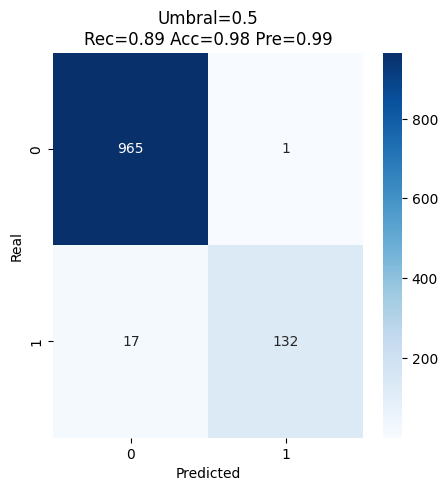

In [30]:
# Celda 18: Cálculo y Visualización de Métricas
# Esta celda realiza la evaluación final, calculando la matriz de confusión y las métricas clave (Accuracy, Recall, Precision).

# Umbral de clasificación: si la probabilidad es >= 0.5, se clasifica como spam (1)
umbral=0.5
y_pred=y_pred_probs[:]>=umbral # Convierte las probabilidades a etiquetas binarias (True/False)

# Configura la figura para la visualización de la matriz de confusión
fig, axes = plt.subplots(1,1)
fig.set_size_inches(5, 5)

# Calcula la Matriz de Confusión (True vs. Predicted)
matriz = confusion_matrix(y_val, y_pred)
ax=axes

# Genera el heatmap (mapa de calor) de la matriz de confusión con la librería Seaborn
sns.heatmap(matriz, annot=True, ax = ax, cmap="Blues",fmt="d");

# Establece el título del gráfico, incluyendo las métricas clave
ax.set_title("Umbral="+str(umbral)+"\nRec="+str(round(recall_score(y_val, y_pred),2))+
" Acc="+str(round(accuracy_score(y_val, y_pred),2))+
" Pre="+str(round(precision_score(y_val, y_pred),2)))

# Etiqueta los ejes
axes.set_xlabel('Predicted') # Etiqueta para las predicciones
axes.set_ylabel('Real')      # Etiqueta para los valores reales